In [1]:
# SETUP
# First, we have to import the program into our Jupyter notebook:
from opticalc_330 import *

# The following lines allow plots to be displayed inside the Jupyter notebook
from IPython.display import Image, display
get_ipython().run_line_magic('matplotlib', 'inline')

# Here we import some additional libraries
import numpy as np
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "monospace",})

# We can use the testImport() function to see if the opticalc library has been imported correctly:
testImport()
# If the program was imported correctly, it should print <Import successful.> to standard output
# when this block is executed by pressing "Shift" + "Enter"

Import successful.


Multiple files begining with Au found. Using <Au_BabarWeaver_2015.csv>.
Multiple files begining with H2O found. Using <H2O_HaleQuerry_1973_full.csv>.


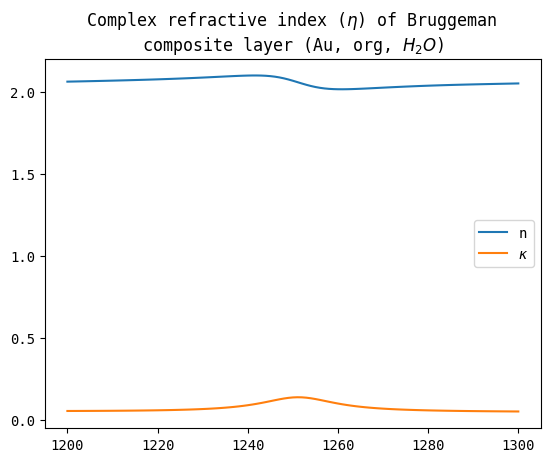

In [2]:
# INITIAL PARAMETERS
# Let's create a calculate an Kretschmann-configuration ATR absorbance spectrum of a 1 nm layer of some 
# test molecule on a sputtered ITO film with electrodeposited gold, all supported on a silicon ATR crystal. 
# First, we start off by creating a materials object that defines the basic parameters of the calculation. 
# We'll choose to do a simulation at a fixed angle of 60 degrees, and we'll plot the range of 1200 and 1300 
# wavenumbers with a resolution of 1 wavenumber (i.e. doing a calculation for each wavenumber), which will 
# require 101 data points: 
mat = materials('frequency', 60, 1200, 1300, 101)

# DEFINING MATERIALS
# Next we will need to define the permittivity values of the materials. The materials() object has several methods
# available to assist with this. First, we will define the refractive index of Si to be 3.4 at all wavenumbers: 
mat.setFixed("Si", 3.4)

# Next, we'll model the test molecule as a Lorentz oscillator with B = 30000 cm-2, γ = 20 cm-1, ε∞ = 1.8, 
# and νresonant = 1250 cm-1. This function supports Lorentz oscillators with multiple resonances, so
# νplasma, γ, and νresonant must be provided as arrays, which are indicated with [ ].
mat.setLorentz("org", [30000], [20], 1.8, [1250])

#  Next, we can define the permittivity of the conductive ITO underlayer using the Drude model.
# In this case, we will se the parameters: νP = 17000 cm-1, νD = 900 cm-1 and ε∞ = 3.8
mat.setDrude("ITOc", 17000, 900, 3.8)

#  Finally, we will read in the permittivity values of gold and water from the csv file. This function can 
# import multiple files in one go, so it expects an array of strings: 
mat.importMat(["Au", "H2O"])

# We have now defined the permittivity values of our bulk materials. However, the interface of the working 
# electrode is a rough surface made up of nanoparticles, coated with the test molecule, and immersed in the 
# electrolyte. This type of inhomogeneous system is not properly modelled by a uniform slab of a single material.
# Rather than fully model this complex system, we can use an effective medium approximation (EMA), provided that
# the structure of the nanoparticles is significantly smaller than the wavelength of light.

# In this example, I will demonstrate the use of the "setMultiBruggeman() method which enables the calculation 
# of the effective permittivity of a composite containing spherical constituent particles made of n-many 
# different materials. As with all of the permittivity-defining methods, the first argument we must provide is 
# a string to identify the material, in this case I will call it "Samp_multiDroplet". Next, we provide an array 
# listing the material IDs of the nanoparticles, ["Au", "org", "H2O"]. The last parameter we must provide is an
# array of the fractional volumes occupied by nanoparticles, in the same order that corresponds to the order 
# that the IDs were provided. 
f1 = 0.2 # fill fraction of gold
f2samp = 0.1 # fill fraction of organic oscillator test molecule
mat.setMultiBruggeman("Samp_multiDroplet", ["Au", "org", "H2O"], [f1, f2samp, 1.0-f1-f2samp])

# We also need a reference case where the "org" particles are absent: 
mat.setMultiBruggeman("Ref_multiDroplet", ["Au", "H2O"], [f1, 1.0-f1])

# Note that permittivity, ε, and complex refractive index, η, are two different ways of representing the 
# same information. All of the above methods that we used to calculate ε also automatically calculate η 
# and both are stored as entries in a dictionary. The ε value can be accessed with the key ["eps"] and the
# η value can be accessed with the key ["eta"]. Each of ε and η are stored as the numpy data type complex. 
# For example, this is how one would plot the complex refractive index of the sample Bruggeman composite: 
x = mat.nu
y1 = np.real(mat.matDict["Samp_multiDroplet"]["eta"]) # The value of n
y2 = np.imag(mat.matDict["Samp_multiDroplet"]["eta"]) # The value of kappa
plt.plot(x, y1, x, y2)
plt.legend(["n", "$\kappa$"])
plt.title("Complex refractive index ($\eta$) of Bruggeman \ncomposite layer (Au, org, $H_2O$)")
plt.show()

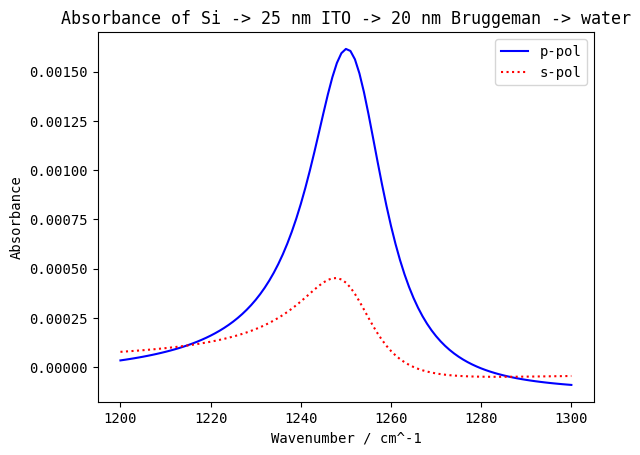

In [3]:
# SETTIN UP A CALCULATION
#  At this point we have collected the permittivity functions of all of our component materials and are ready 
# to define the parameters of the calculation. We will create a PhaseSys object with 4 layers (silicon, ITO, 
# heterogeneous "rough" gold, water). Then we will specify the order of the material of the layers starting 
# with the incident phase: 

# Here is the "sample" spectrum
samp = phaseSys(4, mat)
samp.setLayers(["Si", "ITOc", "Samp_multiDroplet", "H2O"])

# Now we need to provide the thicknesses of the layers. The terminal layers are considered to be semi-infinite,
# so for a system of n layers, n-2 thickness values are required. Here, we will make the ITO layer 25 nm, and 
# the the Bruggeman layer is 20 nm: 
samp.setThicknesses([25,20])

#Finally, we can specify the type of calculation. Here we will calculate the reflectivity: 
Rp_samp = samp.calcR("p") # p-polarized reflectivity
Rs_samp = samp.calcR("s") # s-polarized reflectivity

# The same setup and calculations can be repeated for the "reference" reflectivity spectrum: 
ref = phaseSys(4, mat)
ref.setLayers(["Si", "ITOc", "Ref_multiDroplet", "H2O"])
ref.setThicknesses([25,20])
Rp_ref = ref.calcR("p")
Rs_ref = ref.calcR("s")

# Finally, the absorptivity spectrum can be calculated from: A = -log10(Rp_samp / Rp_ref), and this result
# can be plotted:
Abs_p = -np.log10(Rp_samp/Rp_ref)
Abs_s = -np.log10(Rs_samp/Rs_ref)
plt.plot(mat.nu, Abs_p, c="blue", ls="solid")
plt.plot(mat.nu, Abs_s, c="red", ls = "dotted")
plt.legend(["p-pol", "s-pol"])
plt.title("Absorbance of Si -> 25 nm ITO -> 20 nm Bruggeman -> water")
plt.xlabel("Wavenumber / cm^-1")
plt.ylabel("Absorbance")
plt.show()